# Analyzing the Spectrum of Explainability in Outcome-Oriented Predictive Process Monitoring

## BPIC2015_2_f2

### data preprocessing

#### importing libraries and terminology

In [1]:
#import libraries

In [2]:
import pandas as pd
import numpy as np
import time
import os
import random
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
import xgboost as xgb

In [3]:
#user specified packages from Teinemaa
from DatasetManager import DatasetManager

In [4]:
#tree packages
import graphviz
from sklearn import tree

#LSTM
import numpy as np
import pandas as pd
from pandas import Series
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import logging
plt.style.use('fivethirtyeight')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json

from collections import OrderedDict
from collections import defaultdict

import tensorflow.keras
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Reshape, Activation, Multiply, TimeDistributed, concatenate, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import OrdinalEncoder

C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\ten

Terminology

In [5]:
params_dir = './params_dir'
results_dir = './results' 
cls_encoding = 'agg'

gap = 1
n_iter = 1

bucket_encoding = "agg"

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

In [6]:
#terminology

In [7]:
dataset_ref = 'bpic2015_2_f2'

In [8]:
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

In [9]:
# print dataset name

In [10]:
for dataset_name in datasets:
    print('Dataset:', dataset_name)

Dataset: bpic2015_2_f2


In [11]:
# read the data

In [12]:
dataset_manager = DatasetManager(dataset_name)

In [13]:
data = dataset_manager.read_dataset()
cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

In [14]:
#terminology

In [15]:
params_dir = './params_dir'
results_dir = './results' 
DT_dir = './DT_dir'
cls_encoding = 'agg'

gap = 1
n_iter = 1

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

train_ratio = 0.8
random_state = 22

In [16]:
# determine min and max (truncated) prefix lengths

In [17]:
min_prefix_length = 1
if "traffic_fines" in dataset_name:
    max_prefix_length = 10
elif "bpic2017" in dataset_name:
    max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
else:
    max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

#### data preprocessing

In [18]:
# split into training and test
train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

In [19]:
#prefix generation of train and test data

In [20]:
print('prefixing started')
dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

prefixing started


In [21]:
dt_train_prefixes_original = dt_train_prefixes.copy()
dt_test_prefixes_original = dt_test_prefixes.copy()

In [22]:
#get the label of the train and test set
test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   

In [23]:
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
offline_total_times = []
online_event_times = []

In [24]:
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))  
test_y_all.extend(test_y)

### LSTM

#### poging 5

In [25]:
#functions

def prepare_inputs(X_train, X_test, data):    
    oe = OrdinalEncoder()
    oe.fit(data)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def numeric_padding(sequences, maxlen=None, value=0):
    num_samples = len(sequences)
    sample_shape = np.asarray(sequences[0]).shape[1:]
    x = np.full((num_samples, maxlen) + sample_shape, value)
    for idx, s in enumerate(sequences):
        trunc = s[:maxlen]
        x[idx, :maxlen] = trunc[0]
        
def normalist(lst):
    s = sum(lst)
    norm = [float(i)/s for i in lst]
    return norm

    return x   

In [26]:
#TRANSFORMATION

#categorical columns integercoded

dt_train_prefixes.dtypes

Responsible_actor                                            object
SUMleges                                                    float64
Case ID                                                      object
label                                                        object
Aanleg (Uitvoeren werk of werkzaamheid)                     float64
Bouw                                                        float64
Brandveilig gebruik (melding)                               float64
Brandveilig gebruik (vergunning)                            float64
Gebiedsbescherming                                          float64
Handelen in strijd met regels RO                            float64
Inrit/Uitweg                                                float64
Kap                                                         float64
Milieu (melding)                                            float64
Milieu (neutraal wijziging)                                 float64
Milieu (omgevingsvergunning beperkte milieutoets

In [27]:
dt_train_prefixes.head()

,Responsible_actor,SUMleges,Case ID,label,Aanleg (Uitvoeren werk of werkzaamheid),Bouw,Brandveilig gebruik (melding),Brandveilig gebruik (vergunning),Gebiedsbescherming,Handelen in strijd met regels RO,...,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,case_length,prefix_nr,orig_case_id
0,560458,0.0000,3871304,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,22.0,0.0,0.0,1.0,1.0,40,1,3871304
1,560458,84.3000,3461877,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,3.0,22.0,0.0,0.0,1.0,2.0,40,1,3461877
2,560458,1698.2235,3466211,regular,0.0,1.0,0.0,0.0,0.0,0.0,...,10.0,6.0,22.0,0.0,0.0,1.0,4.0,40,1,3466211
3,560458,84.3000,3467931,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,6.0,22.0,0.0,0.0,1.0,4.0,40,1,3467931
6,560458,84.3000,3467726,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,22.0,0.0,0.0,1.0,5.0,40,1,3467726


In [28]:
cat_columns = ['Activity', 'question','monitoringResource','org:resource', 'Responsible_actor']

dt_train_prefixes[cat_columns],dt_test_prefixes[cat_columns]= prepare_inputs(dt_train_prefixes[cat_columns], dt_test_prefixes[cat_columns], data[cat_columns])

dt_train_prefixes[cat_columns] = dt_train_prefixes[cat_columns]+1

dt_test_prefixes[cat_columns] = dt_test_prefixes[cat_columns]+1

#make embeddings

dt_train_prefixes.dtypes

cat_columns.append('Case ID')
cat_columns.append('label')

cat_columns

ans_train = [pd.DataFrame(y) for x, y in dt_train_prefixes[cat_columns].groupby('Case ID', as_index=False)]
ans_test = [pd.DataFrame(y) for x, y in dt_test_prefixes[cat_columns].groupby('Case ID', as_index=False)]

train_labels = []
for i in range (0,len(ans_train)):
    temp_label = ans_train[i]['label'].iloc[0]
    train_labels.append(temp_label)

test_labels = []
for i in range (0,len(ans_test)):
    temp_label = ans_test[i]['label'].iloc[0]
    test_labels.append(temp_label)

train_y = [1 if i!='regular' else 0 for i in train_labels]
test_y = [1 if i!='regular' else 0 for i in test_labels]

cat_columns.remove('label')
cat_columns.remove('Case ID')

cat_columns

['Activity',
 'question',
 'monitoringResource',
 'org:resource',
 'Responsible_actor']

In [29]:
maxlen = cutoff = 40

In [30]:
#cutoff: max amount of events in a prefix
cutoff = 40
no_activities= len(data.groupby(['Activity']))+1
no_question= len(data.groupby(['question']))+1
no_monitoring= len(data.groupby(['monitoringResource']))+1
no_orgresource= len(data.groupby(['org:resource']))+1
no_responsibleactor = len(data.groupby(['Responsible_actor']))+1

In [31]:
#padding of the different categorical columns
#train paddings
paddings_train = []
for i in cat_columns:
    padding= []
    for k in range(0,len(ans_train)):
        temp = []
        temp = list(ans_train[k][i])
        padding.append(temp)
    
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/len(data.groupby([i]))
    paddings_train.append(padded)

#test paddings
paddings_test = []
for i in cat_columns:
    padding= []
    for k in range(0,len(ans_test)):
        temp = []
        temp = list(ans_test[k][i])
        padding.append(temp)
    
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/len(data.groupby([i]))
    paddings_test.append(padded)

In [32]:
##### numerical columns
#NUMERICAL COLUMNS
cat_columns = ['Activity', 'question','monitoringResource','org:resource', 'Responsible_actor']
numerical_columns = ['Milieu (vergunning)','Kap', 'Milieu (neutraal wijziging)','Gebiedsbescherming',
                     'month', 'timesincecasestart', 'weekday','open_cases','Inrit/Uitweg','Case ID','timesincelastevent']

dt_train_prefixes2 = dt_train_prefixes[numerical_columns]
dt_test_prefixes2 = dt_test_prefixes[numerical_columns]

ans_train2 = [pd.DataFrame(y) for x,y in dt_train_prefixes2.groupby('Case ID', as_index=False)]
ans_test2 = [pd.DataFrame(y) for x,y in dt_test_prefixes2.groupby('Case ID', as_index=False)]

In [33]:
pad_train = []
pad_test  = []
num_columns = ['Milieu (vergunning)','Kap', 'Milieu (neutraal wijziging)','Gebiedsbescherming',
                     'month', 'timesincecasestart', 'weekday','open_cases','Inrit/Uitweg', 'timesincelastevent']
for i in num_columns:
    padding = []
    for k in range(0,len(ans_train2)):
        temp_train = []
        temp_train = list(ans_train2[k][i])
        padding.append(temp_train)
        
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/data[i].max()
    pad_train.append(padded)
for i in num_columns:
    padding = []
    for k in range(0,len(ans_test2)):
        temp_test = []
        temp_test = list(ans_test2[k][i])
        padding.append(temp_test)
        
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/data[i].max()
    pad_test.append(padded)

In [34]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import non_neg, Constraint
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve


from tensorflow.keras.layers import Input, Concatenate, Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional,TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Softmax, Lambda, Multiply, Dropout
from tensorflow.keras import backend
from tensorflow.keras.layers import GlobalAveragePooling1D
import tensorflow.keras.utils as ku

In [35]:
def create_index(log_df, column):
    """Creates an idx for a categorical attribute.
    Args:
        log_df: dataframe.
        column: column name.
    Returns:
        index of a categorical attribute pairs.
    """
    temp_list = log_df[[column]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    subsec_set = sorted(list(subsec_set))
    alias = dict()
    for i, _ in enumerate(subsec_set):
        alias[subsec_set[i]] = i + 1
    return alias


ac_index = create_index(dt_train_prefixes_original, 'Activity')
ac_index['Start'] = 0
ac_index['End'] = len(ac_index)
index_ac = {v: k for k, v in ac_index.items()}

q_index = create_index(dt_train_prefixes_original, 'question')
q_index['Start'] = 0
q_index['End'] = len(q_index)
index_q = {v: k for k, v in q_index.items()}

m_index = create_index(dt_train_prefixes_original, 'monitoringResource')
m_index['Start'] = 0
m_index['End'] = len(m_index)
index_m = {v: k for k, v in m_index.items()}

o_index = create_index(dt_train_prefixes_original, 'org:resource')
o_index['Start'] = 0
o_index['End'] = len(o_index)
index_o = {v: k for k, v in o_index.items()}

r_index = create_index(dt_train_prefixes_original, 'Responsible_actor')
r_index['Start'] = 0
r_index['End'] = len(r_index)
index_r = {v: k for k, v in r_index.items()}


ac_weights = ku.to_categorical(sorted(index_ac.keys()), len(ac_index))
q_weights = ku.to_categorical(sorted(index_q.keys()), len(q_index))
m_weights = ku.to_categorical(sorted(index_m.keys()), len(m_index))
o_weights = ku.to_categorical(sorted(index_o.keys()), len(o_index))
r_weights = ku.to_categorical(sorted(index_r.keys()), len(r_index))

In [36]:
dropout_input = 0.01
dropout_context=0.30
lstm_size_alpha=32
lstm_size_beta=32
print("Training prefix and variable attention model")

l2reg=0.001
#Code Input
#categorical embeddings
input_layer_a = Input(shape=(cutoff,), name='activity_input')

input_layer_q = Input(shape=(cutoff,), name='question_input')

input_layer_m = Input(shape=(cutoff,), name='monitoring_input')

input_layer_o = Input(shape=(cutoff,), name='orgresource_input')

input_layer_r = Input(shape=(cutoff,), name='responsibleactor_input')

time_input_layer = Input(shape=(cutoff,1), name='time_input')

########################################
#inputs_list = [ac_input]
   
#Calculate embedding for each code and sum them to a visit level
embedding_activity = Embedding(ac_weights.shape[0],
                            ac_weights.shape[1],
                            weights=[ac_weights],
                            input_length=no_activities,
                           name='ac_embedding')(input_layer_a)
dim =ac_weights.shape[1]

embedding_question = Embedding(q_weights.shape[0],
                            q_weights.shape[1],
                            weights=[q_weights],
                            input_length=no_question,
                             name='q_embedding')(input_layer_q)

dim += q_weights.shape[1]


embedding_monitoring = Embedding(m_weights.shape[0],
                            m_weights.shape[1],
                            weights=[m_weights],
                            input_length=no_monitoring,
                             name='m_embedding')(input_layer_m)
dim += m_weights.shape[1]

embedding_orgresource = Embedding(o_weights.shape[0],
                            o_weights.shape[1],
                            weights=[o_weights],
                            input_length=no_orgresource,
                             name='o_embedding')(input_layer_o)

dim += o_weights.shape[1]

embedding_responsibleactor = Embedding(r_weights.shape[0],
                            r_weights.shape[1],
                            weights=[r_weights],
                            input_length=no_responsibleactor,
                             name='r_embedding')(input_layer_r)

dim += r_weights.shape[1]

input_layer_numeric0 = Input(shape=(cutoff,1), name='numeric_input0')
input_layer_numeric1 = Input(shape=(cutoff,1), name='numeric_input1')
input_layer_numeric2 = Input(shape=(cutoff,1), name='numeric_input2')
input_layer_numeric3 = Input(shape=(cutoff,1), name='numeric_input3')
input_layer_numeric4 = Input(shape=(cutoff,1), name='numeric_input4')
input_layer_numeric5 = Input(shape=(cutoff,1), name='numeric_input5')
input_layer_numeric6 = Input(shape=(cutoff,1), name='numeric_input6')
input_layer_numeric7 = Input(shape=(cutoff,1), name='numeric_input7')
input_layer_numeric8 = Input(shape=(cutoff,1), name='numeric_input8')

concatenated_numeric = concatenate([input_layer_numeric0,input_layer_numeric1,input_layer_numeric2,
                                  input_layer_numeric3,input_layer_numeric4,input_layer_numeric5,
                                 input_layer_numeric6,input_layer_numeric7,input_layer_numeric8])

dim += 9



full_embs = concatenate([embedding_activity, embedding_question, embedding_monitoring, embedding_orgresource, 
                         embedding_responsibleactor, concatenated_numeric], name='catInp')

#Apply dropout on inputs
full_embs = Dropout(dropout_input)(full_embs)
time_embs = concatenate([full_embs, time_input_layer], name='allInp')

dim += 1

alpha = Bidirectional(LSTM(lstm_size_alpha, return_sequences=True),
                                    name='alpha')
beta = Bidirectional(LSTM(lstm_size_beta, return_sequences=True),
                                   name='beta')
alpha_dense = Dense(1, kernel_regularizer=l2(l2reg))
beta_dense = Dense(dim, activation='tanh', kernel_regularizer=l2(l2reg))

#Compute alpha, visit attention
alpha_out = alpha(time_embs)
alpha_out = TimeDistributed(alpha_dense, name='alpha_dense_0')(alpha_out)
alpha_out = Softmax(axis=1, name='alpha_softmax')(alpha_out)
#Compute beta, codes attention
beta_out = beta(time_embs)
beta_out = TimeDistributed(beta_dense, name='beta_dense_0')(beta_out)
#Compute context vector based on attentions and embeddings
c_t = Multiply()([alpha_out, beta_out, time_embs])
c_t = Lambda(lambda x: backend.sum(x, axis=1))(c_t)
        #Reshape to 3d vector for consistency between Many to Many and Many to One implementations
        #contexts = L.Lambda(reshape)(c_t)

#Make a prediction
contexts = Dropout(dropout_context)(c_t)
 
output_layer = Dense(1, activation='sigmoid', name='final_output')(contexts)

Training prefix and variable attention model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [37]:
model = Model(inputs=[input_layer_a, input_layer_q, input_layer_m, input_layer_o, input_layer_r,input_layer_numeric0,input_layer_numeric1,input_layer_numeric2,input_layer_numeric3,
                      input_layer_numeric4,input_layer_numeric5,input_layer_numeric6,input_layer_numeric7,
                      input_layer_numeric8,
                       time_input_layer], outputs=output_layer)

In [38]:
opt = Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999,
                   epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'final_output':'binary_crossentropy'}, optimizer= opt)
    
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
activity_input (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
monitoring_input (InputLayer)   [(None, 40)]         0                                            
__________________________________________________________________________________________________
orgresource_input (InputLayer)  [(None, 40)]         0                                            


In [39]:
output_file_path = os.path.join('./', 'models/model_rd_'+'_{epoch:02d}-{val_loss:.2f}.h5')

In [40]:
padded_time = np.reshape(pad_train[9], (len(pad_train[9]), cutoff, 1))
padded_time_test=  np.reshape(pad_test[9], (len(pad_test[9]), cutoff, 1))
pad_0 = np.reshape(pad_train[0], (len(pad_train[0]), cutoff, 1))
pad_0_test = np.reshape(pad_test[0], (len(pad_test[0]), cutoff, 1))
pad_1 = np.reshape(pad_train[1], (len(pad_train[1]), cutoff, 1))
pad_1_test = np.reshape(pad_test[1], (len(pad_test[1]), cutoff, 1))
pad_2 = np.reshape(pad_train[2], (len(pad_train[2]), cutoff, 1))
pad_2_test = np.reshape(pad_test[2], (len(pad_test[2]), cutoff, 1))
pad_3 = np.reshape(pad_train[3], (len(pad_train[3]), cutoff, 1))
pad_3_test = np.reshape(pad_test[3], (len(pad_test[3]), cutoff, 1))
pad_4 = np.reshape(pad_train[4], (len(pad_train[4]), cutoff, 1))
pad_4_test = np.reshape(pad_test[4], (len(pad_test[4]), cutoff, 1))
pad_5 = np.reshape(pad_train[5], (len(pad_train[5]), cutoff, 1))
pad_5_test = np.reshape(pad_test[5], (len(pad_test[5]), cutoff, 1))
pad_6 = np.reshape(pad_train[6], (len(pad_train[6]), cutoff, 1))
pad_6_test = np.reshape(pad_test[6], (len(pad_test[6]), cutoff, 1))
pad_7 = np.reshape(pad_train[7], (len(pad_train[7]), cutoff, 1))
pad_7_test = np.reshape(pad_test[7], (len(pad_test[7]), cutoff, 1))
pad_8 = np.reshape(pad_train[8], (len(pad_train[8]), cutoff, 1))
pad_8_test = np.reshape(pad_test[8], (len(pad_test[8]), cutoff, 1))

model_checkpoint = ModelCheckpoint(output_file_path,
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5,
                                   patience=2,
                                   verbose=0,
                                   mode='auto',
                                   min_delta=0.0001,
                                   cooldown=0,
                                   min_lr=0)
model_inputs = [paddings_train[0]]
model_inputs.append(paddings_train[1])
model_inputs.append(paddings_train[2])
model_inputs.append(paddings_train[3])
model_inputs.append(paddings_train[4])
model_inputs.append(pad_0)
model_inputs.append(pad_1)
model_inputs.append(pad_2)
model_inputs.append(pad_3)
model_inputs.append(pad_4)
model_inputs.append(pad_5)
model_inputs.append(pad_6)
model_inputs.append(pad_7)
model_inputs.append(pad_8)
model_inputs.append(padded_time)

In [41]:
start = time.time()
model.fit(model_inputs,
              train_y,
              callbacks=[early_stopping, lr_reducer],
              validation_split = 0.1,
              verbose=1,
              epochs=10)
model_inputs_test = [paddings_test[0]]
model_inputs_test.append(paddings_test[1])
model_inputs_test.append(paddings_test[2])
model_inputs_test.append(paddings_test[3])
model_inputs_test.append(paddings_test[4])
model_inputs_test.append(pad_0_test)
model_inputs_test.append(pad_1_test)
model_inputs_test.append(pad_2_test)
model_inputs_test.append(pad_3_test)
model_inputs_test.append(pad_4_test)
model_inputs_test.append(pad_5_test)
model_inputs_test.append(pad_6_test)
model_inputs_test.append(pad_7_test)
model_inputs_test.append(pad_8_test)
model_inputs_test.append(padded_time_test)
predictions = model.predict(model_inputs_test)
auc = roc_auc_score(test_y,predictions)
total_time = time.time() - start
print(total_time)
print(auc)

Train on 19998 samples, validate on 2223 samples
Epoch 1/10
19998/19998 [==============================] - 63s 3ms/sample - loss: 0.4538 - val_loss: 0.5191
Epoch 2/10
19998/19998 [==============================] - 59s 3ms/sample - loss: 0.4001 - val_loss: 0.4960
Epoch 3/10
19998/19998 [==============================] - 56s 3ms/sample - loss: 0.3794 - val_loss: 0.5066
Epoch 4/10
19998/19998 [==============================] - 57s 3ms/sample - loss: 0.3679 - val_loss: 0.5065
Epoch 5/10
19998/19998 [==============================] - 60s 3ms/sample - loss: 0.3457 - val_loss: 0.4844
Epoch 6/10
19998/19998 [==============================] - 60s 3ms/sample - loss: 0.3406 - val_loss: 0.4752
Epoch 7/10
19998/19998 [==============================] - 60s 3ms/sample - loss: 0.3315 - val_loss: 0.4756
Epoch 8/10
19998/19998 [==============================] - 61s 3ms/sample - loss: 0.3275 - val_loss: 0.5540
Epoch 9/10
19998/19998 [==============================] - 60s 3ms/sample - loss: 0.3287 - val_l

In [42]:
preds_all = predictions
method_name = "attention"
cls_method = "LSTM"

In [43]:
if gap > 1:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
else:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [44]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", total_time/10))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": list(preds_all), "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(auc))

In [45]:
cat_columns = ['Activity', 'question','monitoringResource','org:resource', 'Responsible_actor']
numerical_columns = ['Milieu (vergunning)','Kap', 'Milieu (neutraal wijziging)','Gebiedsbescherming',
                     'month', 'timesincecasestart', 'weekday','open_cases','Inrit/Uitweg','timesincelastevent']


In [46]:
#   Next event selection method and numbers of repetitions
#variants = [{'imp': 'Arg Max', 'rep': 1}]#,
               # {'imp': 'Random Choice', 'rep': 1}]
#   Generation of predictions
has_time=False
    #model = load_model(os.path.join(output_route, parameters['model_file']))
model = model
layer_names = [layer.name for layer in model.layers]
print(layer_names)
l_emb_weights=None
ac_emb_weights = model.get_layer(name='ac_embedding').get_weights()[0]

q_emb_weights = model.get_layer(name='q_embedding').get_weights()[0]
    
m_emb_weights = model.get_layer(name='m_embedding').get_weights()[0]  
    
o_emb_weights = model.get_layer(name='o_embedding').get_weights()[0]  
    
r_emb_weights = model.get_layer(name='r_embedding').get_weights()[0]  

has_time=True

ac_output_weights, ac_bias = model.get_layer(name='final_output').get_weights()
model_with_attention = Model(model.inputs, model.outputs +\
                                              [model.get_layer(name='alpha_softmax').output,\
                                               model.get_layer(name='beta_dense_0').output])

['activity_input', 'question_input', 'monitoring_input', 'orgresource_input', 'responsibleactor_input', 'numeric_input0', 'numeric_input1', 'numeric_input2', 'numeric_input3', 'numeric_input4', 'numeric_input5', 'numeric_input6', 'numeric_input7', 'numeric_input8', 'ac_embedding', 'q_embedding', 'm_embedding', 'o_embedding', 'r_embedding', 'concatenate', 'catInp', 'dropout', 'time_input', 'allInp', 'alpha', 'alpha_dense_0', 'beta', 'alpha_softmax', 'beta_dense_0', 'multiply', 'lambda', 'dropout_1', 'final_output']


In [47]:
temporal_vectors = []
variable_vectors=[]
predictions = []
for i in range(0,len(paddings_test[0])):
    x_ac_ngram = paddings_test[0][i].reshape((1,cutoff))
    x_q_ngram = paddings_test[1][i].reshape((1,cutoff))
    x_m_ngram = paddings_test[2][i].reshape((1,cutoff))
    x_o_ngram = paddings_test[3][i].reshape((1,cutoff))
    x_r_ngram = paddings_test[4][i].reshape((1,cutoff))
    x_in_ngram0  = pad_0_test[i].reshape(1, 40, 1)
    x_in_ngram1  = pad_1_test[i].reshape(1, 40, 1)
    x_in_ngram2  = pad_2_test[i].reshape(1, 40, 1)
    x_in_ngram3  = pad_3_test[i].reshape(1, 40, 1)
    x_in_ngram4  = pad_4_test[i].reshape(1, 40, 1)
    x_in_ngram5  = pad_5_test[i].reshape(1, 40, 1)
    x_in_ngram6  = pad_6_test[i].reshape(1, 40, 1)
    x_in_ngram7  = pad_7_test[i].reshape(1, 40, 1)
    x_in_ngram8  = pad_8_test[i].reshape(1, 40, 1)
    x_t_ngram   = padded_time_test[i].reshape(1, 40, 1)
    betas=None      
    proba, alphas, betas = model_with_attention.predict([x_ac_ngram, x_q_ngram, x_m_ngram, x_o_ngram, x_r_ngram, 
                                                         x_in_ngram0,x_in_ngram1,x_in_ngram2,x_in_ngram3,x_in_ngram4,
                                                         x_in_ngram5,x_in_ngram6,x_in_ngram7,x_in_ngram8,x_t_ngram])
    #print(proba, alphas, betas)
    proba = np.squeeze(proba)
    alphas = np.squeeze(alphas)
    temporal_att_vec = alphas
    assert (np.sum(temporal_att_vec) - 1.0) < 1e-5
    #print(temporal_att_vec)
    temporal_vectors.append(temporal_att_vec)

    if betas is not None:
        #get the beta value
        betas = np.squeeze(betas)
        idx = np.argmax(alphas)
        #print(idx)
        beta_val = betas[idx]
        # get the activity and role for that idx
        act_ip = int(x_ac_ngram[0][idx])
        ac_emb = ac_emb_weights[act_ip]
        dim=ac_emb.shape[0]
        
        rol_ip = int(x_q_ngram[0][idx])
        q_emb = q_emb_weights[rol_ip]
        dim += q_emb.shape[0]
            
       
        rol_ip = int(x_m_ngram[0][idx])
        m_emb = m_emb_weights[rol_ip]
        dim += m_emb.shape[0]
        
        
        rol_ip = int(x_o_ngram[0][idx])
        o_emb = o_emb_weights[rol_ip]
        dim += o_emb.shape[0]
           
        
        rol_ip = int(x_r_ngram[0][idx])
        r_emb = r_emb_weights[rol_ip]
        dim += r_emb.shape[0]
            
        num_v0 = np.squeeze(x_in_ngram0)[idx]
        num_v1 = np.squeeze(x_in_ngram1)[idx]
        num_v2 = np.squeeze(x_in_ngram2)[idx]
        num_v3 = np.squeeze(x_in_ngram3)[idx]
        num_v4 = np.squeeze(x_in_ngram4)[idx]
        num_v5 = np.squeeze(x_in_ngram5)[idx]
        num_v6 = np.squeeze(x_in_ngram6)[idx]
        num_v7 = np.squeeze(x_in_ngram7)[idx]
        num_v8 = np.squeeze(x_in_ngram8)[idx]
        dim +=9
        
        if(betas.shape[1]==dim+1):
            time_v = np.squeeze(x_t_ngram)[idx]  # time and role as masked together
            emb = np.concatenate((ac_emb,q_emb,m_emb,o_emb,r_emb,num_v0,num_v1,num_v2,num_v3,num_v4
                                  ,num_v5,num_v6,num_v7,num_v8,time_v), axis=None)
          
        #print('beta_val',beta_val.shape)
        beta_scaled = np.multiply(beta_val,emb)
        variable_attn = alphas[idx] * beta_scaled
        #sum_grad = np.sum(ac_output_weights, axis=1)
        #variable_attn=np.multiply(sum_grad.flatten(), variable_attn)
        #if pos!=test_y[i]:
            #temporal_vectors[i] = np.zeros(40, dtype='float32')
            #variable_attn = np.zeros(52, dtype='float32')
            #variable_vectors.append(variable_attn)
        predictions.append(proba)
        variable_vectors.append(variable_attn)

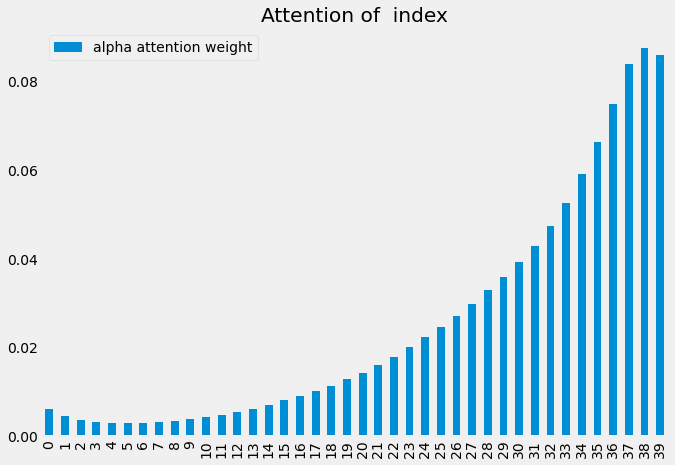

In [48]:
temp_final = np.mean(np.array(temporal_vectors), axis=0)
pd.DataFrame(temp_final, columns=['alpha attention weight']).plot(kind='bar',
                                                                        title='Attention of '
                                                                              ' index', figsize=(10,7))
# Hide grid lines
plt.grid(False)
plt.show()

355
     attributes    attribute_values
0      0.016131               Start
1      0.000048           01_BB_540
2      0.000100           01_BB_765
3     -0.000410           01_BB_770
4      0.000716           01_BB_775
..          ...                 ...
350   -0.000605  timesincecasestart
351    0.001087             weekday
352   -0.020942          open_cases
353    0.003939        Inrit/Uitweg
354   -0.000162  timesincelastevent

[355 rows x 2 columns]


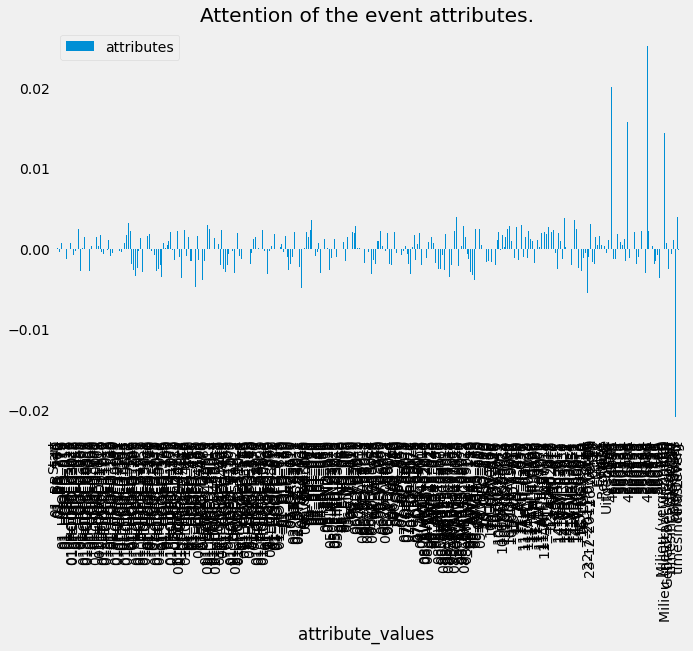

In [49]:
if(len(variable_vectors)>0):
    var_final = np.mean(np.array(variable_vectors), axis=0)
    ac_labels = [index_ac[key] for key in sorted(index_ac.keys())]
    q_labels = [index_q[key] for key in sorted(index_q.keys())]
    m_labels = [index_m[key] for key in sorted(index_m.keys())]
    o_labels = [index_o[key] for key in sorted(index_o.keys())]
    r_labels = [index_r[key] for key in sorted(index_r.keys())]
    
    
      
    num_dim = var_final.shape[0]
    print(num_dim)
      
    ac_labels.extend(q_labels)
    ac_labels.extend(m_labels)
    ac_labels.extend(o_labels)
    ac_labels.extend(r_labels)
  
    ac_labels.append('Milieu (vergunning)')
    ac_labels.append('Kap')
    ac_labels.append('Milieu (neutraal wijziging)')
    ac_labels.append('Gebiedsbescherming')
    ac_labels.append('month')
    ac_labels.append('timesincecasestart')
    ac_labels.append('weekday')
    ac_labels.append('open_cases')
    ac_labels.append('Inrit/Uitweg')
 
    ac_labels.append('timesincelastevent')   
        

    
        
        
        
        
        
    df_var=pd.DataFrame({'attributes':var_final, 'attribute_values':ac_labels})
    print(df_var)
    df_var.plot.bar(y='attributes', x='attribute_values',
                                title='Attention of the event attributes.', figsize=(10,7))
                                                                               
    #plot_history( plt, file_name + 'variable_attn', path )
      

    # Hide grid lines
    plt.grid(False)
    plt.show()

#### Parsimony

In [56]:
parsimony = 0
for i in range(0,len(df_var['attributes'])):
    if df_var['attributes'][i]>0:
        parsimony = parsimony+1
parsimony

174

In [58]:
len(df_var['attributes'])

355

#### Functional Complexity

In [77]:
def functional_complexity(n_instances):
    NF=0
    #categorical_columns
    list_of_random_instances = list(np.random.permutation(np.arange(0,n_instances))[:n_instances])
    for j in range(0,len(paddings_test)):
        for i in list_of_random_instances:
            new_paddings_test = paddings_test.copy()
            #new prediction after permutation 
            new_paddings_test[j][i] = random.uniform(0,1)
            #new_paddings_test[j][i] = np.random.permutation(new_paddings_test[j][i])
            new_model_inputs_test = [[np.array(new_paddings_test[0][i])]]
            new_model_inputs_test.append([np.array(new_paddings_test[1][i])])
            new_model_inputs_test.append([np.array(new_paddings_test[2][i])])
            new_model_inputs_test.append([np.array(new_paddings_test[3][i])])
            new_model_inputs_test.append([np.array(new_paddings_test[4][i])])
            new_model_inputs_test.append([np.array(pad_0_test[i])])
            new_model_inputs_test.append([np.array(pad_1_test[i])])
            new_model_inputs_test.append([np.array(pad_2_test[i])])
            new_model_inputs_test.append([np.array(pad_3_test[i])])
            new_model_inputs_test.append([np.array(pad_4_test[i])])
            new_model_inputs_test.append([np.array(pad_5_test[i])])
            new_model_inputs_test.append([np.array(pad_6_test[i])])
            new_model_inputs_test.append([np.array(pad_7_test[i])])
            new_model_inputs_test.append([np.array(pad_8_test[i])])
            new_model_inputs_test.append([np.array(padded_time_test[i])])
            pred2 = model.predict(new_model_inputs_test)
            pred2= np.round(pred2)
            #prediction without permutation
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            model_inputs_test.append([np.array(paddings_test[1][i])])
            model_inputs_test.append([np.array(paddings_test[2][i])])
            model_inputs_test.append([np.array(paddings_test[3][i])])
            model_inputs_test.append([np.array(paddings_test[4][i])])
            model_inputs_test.append([np.array(pad_0_test[i])])
            model_inputs_test.append([np.array(pad_1_test[i])])
            model_inputs_test.append([np.array(pad_2_test[i])])
            model_inputs_test.append([np.array(pad_3_test[i])])
            model_inputs_test.append([np.array(pad_4_test[i])])
            model_inputs_test.append([np.array(pad_5_test[i])])
            model_inputs_test.append([np.array(pad_6_test[i])])
            model_inputs_test.append([np.array(pad_7_test[i])])
            model_inputs_test.append([np.array(pad_8_test[i])])
            model_inputs_test.append([np.array(padded_time_test[i])])
            pred1 = model.predict(model_inputs_test)
            pred1 = np.round(pred1)
            
            if pred1 == pred2:
                NF = NF+1
    #numerical
    list_of_sets=[]
    set_of_values = set()
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list        
    for j in range(0,len(num_columns)):
        set_of_values = set(dt_test_prefixes[num_columns[j]])
        for i in list_of_random_instances:
            new_pad_test = pad_test.copy()
            new_pad_test[j][i] = random.choice(list(set_of_values))
           
            new_padded_time_test=  np.reshape(new_pad_test[1], (len(new_pad_test[1]), cutoff, 1))
            
            new_pad_0_test = np.reshape(new_pad_test[0], (len(new_pad_test[0]), cutoff, 1))
            new_pad_1_test = np.reshape(new_pad_test[1], (len(new_pad_test[1]), cutoff, 1))
            new_pad_2_test = np.reshape(new_pad_test[2], (len(new_pad_test[2]), cutoff, 1))
            new_pad_3_test = np.reshape(new_pad_test[3], (len(new_pad_test[3]), cutoff, 1))
            new_pad_4_test = np.reshape(new_pad_test[4], (len(new_pad_test[4]), cutoff, 1))
            new_pad_5_test = np.reshape(new_pad_test[5], (len(new_pad_test[5]), cutoff, 1))
            new_pad_6_test = np.reshape(new_pad_test[6], (len(new_pad_test[6]), cutoff, 1))
            new_pad_7_test = np.reshape(new_pad_test[7], (len(new_pad_test[7]), cutoff, 1))
            new_pad_8_test = np.reshape(new_pad_test[8], (len(new_pad_test[8]), cutoff, 1))
  
            
            #new prediction after permutation
           
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            model_inputs_test.append([np.array(paddings_test[1][i])])
            model_inputs_test.append([np.array(paddings_test[2][i])])
            model_inputs_test.append([np.array(paddings_test[3][i])])
            model_inputs_test.append([np.array(paddings_test[4][i])])
            model_inputs_test.append([np.array(new_pad_0_test[i])])
            model_inputs_test.append([np.array(new_pad_1_test[i])])
            model_inputs_test.append([np.array(new_pad_2_test[i])])
            model_inputs_test.append([np.array(new_pad_3_test[i])])
            model_inputs_test.append([np.array(new_pad_4_test[i])])
            model_inputs_test.append([np.array(new_pad_5_test[i])])
            model_inputs_test.append([np.array(new_pad_6_test[i])])
            model_inputs_test.append([np.array(new_pad_7_test[i])])
            model_inputs_test.append([np.array(new_pad_8_test[i])])
            new_model_inputs_test.append([np.array(new_padded_time_test[i])])
            pred2 = model.predict(new_model_inputs_test)
            pred2= np.round(pred2)
            #prediction without permutation
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            model_inputs_test.append([np.array(paddings_test[1][i])])
            model_inputs_test.append([np.array(paddings_test[2][i])])
            model_inputs_test.append([np.array(paddings_test[3][i])])
            model_inputs_test.append([np.array(paddings_test[4][i])])
            model_inputs_test.append([np.array(pad_0_test[i])])
            model_inputs_test.append([np.array(pad_1_test[i])])
            model_inputs_test.append([np.array(pad_2_test[i])])
            model_inputs_test.append([np.array(pad_3_test[i])])
            model_inputs_test.append([np.array(pad_4_test[i])])
            model_inputs_test.append([np.array(pad_5_test[i])])
            model_inputs_test.append([np.array(pad_6_test[i])])
            model_inputs_test.append([np.array(pad_7_test[i])])
            model_inputs_test.append([np.array(pad_8_test[i])])
            model_inputs_test.append([np.array(padded_time_test[i])])
            pred1 = model.predict(model_inputs_test)
            pred1 = np.round(pred1)
            if pred1 == pred2:
                NF = NF+1           
                
    
    return NF

In [80]:
functional_complexity(500)

6580

In [81]:
500*15

7500

#### Monotonicity

In [51]:
numbers = [no_activities, no_question,no_monitoring,no_orgresource,no_responsibleactor,1,1,1,1,1,1,1,1,1,1]

sample_length = 5000
effects_saved = []
def data_sample(model_inputs):
    sample_data = []
    for i in range(0, len(model_inputs)):
        sample_data.append(model_inputs[i][0:sample_length])
    return sample_data
def var_importance(model, model_inputs):
    x = data_sample(model_inputs)
    orig_out = model.predict(x)
    for i in range(0,len(cat_columns)):  # iterate over the 5 cat features
        print(i)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        new_x[i] = np.array(perturbations_list)
        perturbed_out = model.predict(new_x)
        effect = (((orig_out - perturbed_out) ** 2)/40).sum() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        effects_saved.append(effect)
    for k in range(i+1,len(model_inputs)):  # iterate over the 10 num features
        print(k)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        perturbation_array = np.array(perturbations_list)
        perturbations_reshaped = perturbation_array.reshape(sample_length, cutoff, 1)
        new_x[k] = perturbations_reshaped
        perturbed_out = model.predict(new_x)
        effect = (((orig_out - perturbed_out) ** 2)/40).sum() ** 0.5
        print(f'Variable {(k+1)}, perturbation effect: {effect:.4f}')    
        effects_saved.append(effect)

var_importance(model, model_inputs_test)

0
Variable 1, perturbation effect: 0.0055
1
Variable 2, perturbation effect: 0.9296
2
Variable 3, perturbation effect: 0.0000
3
Variable 4, perturbation effect: 0.0000
4
Variable 5, perturbation effect: 0.0000
5
Variable 6, perturbation effect: 2.9643
6
Variable 7, perturbation effect: 1.8950
7
Variable 8, perturbation effect: 2.7693
8
Variable 9, perturbation effect: 6.0172
9
Variable 10, perturbation effect: 1.1423
10
Variable 11, perturbation effect: 0.8819
11
Variable 12, perturbation effect: 1.0288
12
Variable 13, perturbation effect: 1.1563
13
Variable 14, perturbation effect: 1.8607
14
Variable 15, perturbation effect: 1.4154


In [58]:
len([index_ac[key] for key in sorted(index_ac.keys())])

302

In [59]:
abs(df_var['attributes'].iloc[0:302]).sum(skipna = True)

0.42491227

In [60]:
len(q_labels)

14

In [61]:
abs(df_var['attributes'].iloc[302:316]).sum(skipna = True)

0.023549326

In [62]:
len(m_labels)

9

In [63]:
abs(df_var['attributes'].iloc[316:325]).sum(skipna = True)

0.028539583

In [64]:
len(o_labels)

11

In [65]:
abs(df_var['attributes'].iloc[325:336]).sum(skipna = True)

0.030618127

In [66]:
len(r_labels)

9

In [67]:
abs(df_var['attributes'].iloc[336:345]).sum(skipna = True)

0.035494983

In [68]:
num_columns = ['Milieu (vergunning)','Kap', 'Milieu (neutraal wijziging)','Gebiedsbescherming',
                     'month', 'timesincecasestart', 'weekday','open_cases','Inrit/Uitweg', 'timesincelastevent']

In [69]:
abs(df_var['attributes'].iloc[336:345]).sum(skipna = True)


0.035494983

In [70]:
attention_values = []
attention_values.append(0.3627954)
attention_values.append(0.06580403)
attention_values.append(0.016693108)
attention_values.append(0.040122263)
attention_values.append(0.02072303)
attention_values.append(0.016693108)

In [71]:
for i in range(0,9):
    print(abs(df_var['attributes'].iloc[345+i:345+i+1]).sum(skipna = True))
    attention_values.append(abs(df_var['attributes'].iloc[336+i:345+i+1]).sum(skipna = True))

0.0042208247
0.0143883815
0.00071219803
0.0025733206
0.012363204
0.00060467963
0.001086848
0.020941695
0.003939069


In [72]:
cat_columns

['Activity',
 'question',
 'monitoringResource',
 'org:resource',
 'Responsible_actor']

In [73]:
courses = ['Activity',
 'question',
 'monitoringResource',
 'org:resource',
 'Responsible_actor',
 'Milieu (vergunning)',
 'Kap',
 'Milieu (neutraal wijziging)',
 'Gebiedsbescherming',
 'month',
 'timesincecasestart',
 'weekday',
 'open_cases',
 'Inrit/Uitweg',
 'timesincelastevent']

In [74]:
len(courses)

15

In [75]:
len(attention_values)

15

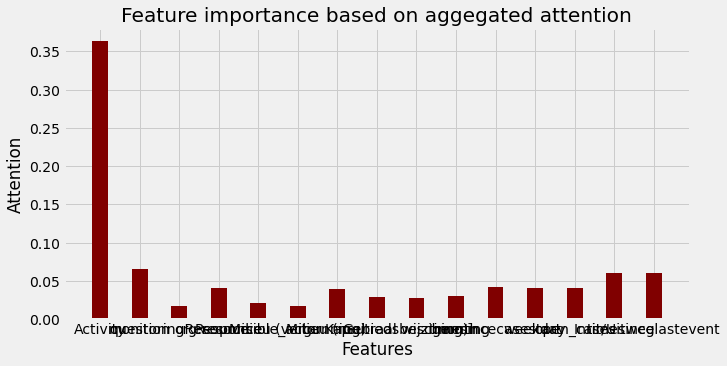

In [76]:
values=attention_values
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("Attention")
plt.title("Feature importance based on aggegated attention")
plt.show()

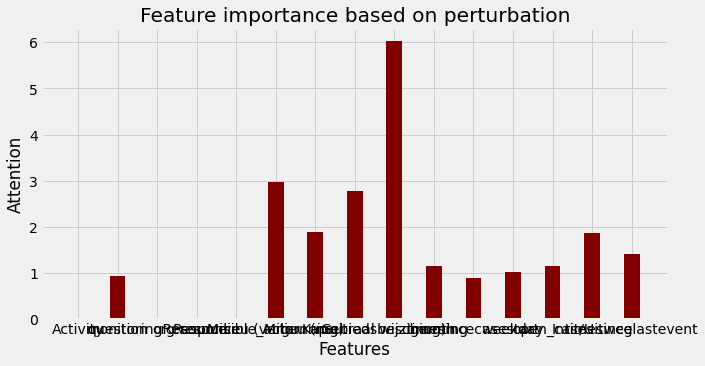

[0.005533887328955449,
 0.9295843371686954,
 0.0,
 0.0,
 0.0,
 2.964331139037553,
 1.8950338110008553,
 2.769292780801326,
 6.017244036896006,
 1.142346898344468,
 0.8819019719574251,
 1.0288004827338075,
 1.1562848987983134,
 1.8606806426462488,
 1.415370778547226]

In [77]:
values = effects_saved
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("Attention")
plt.title("Feature importance based on perturbation")
plt.show()

effects_saved


In [78]:
from scipy.stats import kendalltau

coef, p = kendalltau(effects_saved, attention_values)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)



Kendall correlation coefficient: -0.184
Samples are uncorrelated (fail to reject H0) p=0.344


In [79]:
# prepare data
from scipy.stats import spearmanr
# seed random number generator

coef, p = spearmanr(effects_saved, attention_values)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.161
Samples are uncorrelated (fail to reject H0) p=0.565
